In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import time
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# 1️⃣ Load CIFAR-10
# ----------------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


In [3]:
# ----------------------------
# 2️⃣ Define Teacher and Student
# ----------------------------
teacher = models.resnet50(pretrained=False, num_classes=10).to(device)
student = models.resnet18(pretrained=False, num_classes=10).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# ----------------------------
# 3️⃣ Define Training Utilities
# ----------------------------
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100. * correct / total

In [9]:
# ----------------------------
# 4️⃣ Distillation Loss
# ----------------------------
class DistillationLoss(nn.Module):
    def __init__(self, T=4.0, alpha=0.5):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, true_labels):
        hard_loss = F.cross_entropy(student_logits, true_labels)

        # teacher.
        soft_teacher = F.softmax(teacher_logits / self.T, dim=1)

        # student.
        soft_student = F.log_softmax(student_logits / self.T, dim=1)

        soft_loss = self.kl(soft_student, soft_teacher) * (self.T ** 2)

        return self.alpha * hard_loss + (1 - self.alpha) * soft_loss

In [11]:
# ----------------------------
# 5️⃣ Train Teacher
# ----------------------------
print("Training Teacher Model (ResNet-50)...")
opt_t = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)
for epoch in range(2):  # keep short for demo
    loss = train_one_epoch(teacher, trainloader, opt_t, nn.CrossEntropyLoss())
    acc = evaluate(teacher, testloader)
    print(f"Epoch {epoch+1}: loss={loss:.3f}, acc={acc:.2f}%")

torch.save(teacher.state_dict(), "teacher.pth")

# ----------------------------
# 6️⃣ Train Student with KD
# ----------------------------
print("Training Student Model (ResNet-18) with Distillation...")
teacher.eval()
criterion_kd = DistillationLoss(T=4.0, alpha=0.5)
opt_s = optim.Adam(student.parameters(), lr=0.001)

for epoch in range(2):
    student.train()
    total_loss = 0
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        opt_s.zero_grad()
        with torch.no_grad():
            t_logits = teacher(inputs)
        s_logits = student(inputs)
        loss = criterion_kd(s_logits, t_logits, targets)
        loss.backward()
        opt_s.step()
        total_loss += loss.item()
    acc = evaluate(student, testloader)
    print(f"Epoch {epoch+1}: loss={total_loss/len(trainloader):.3f}, acc={acc:.2f}%")

torch.save(student.state_dict(), "student_kd.pth")

Training Teacher Model (ResNet-50)...
Epoch 1: loss=1.735, acc=45.36%
Epoch 2: loss=1.800, acc=34.55%
Training Student Model (ResNet-18) with Distillation...
Epoch 1: loss=136.384, acc=26.98%
Epoch 2: loss=1.277, acc=37.90%


In [12]:
# ----------------------------
# 7️⃣ Latency Measurement
# ----------------------------
def measure_latency(model, n_runs=50):
    model.eval()
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    torch.cuda.synchronize() if device.type == "cuda" else None
    start = time.time()
    for _ in range(n_runs):
        _ = model(dummy_input)
    torch.cuda.synchronize() if device.type == "cuda" else None
    end = time.time()
    return (end - start) / n_runs * 1000

lat_teacher = measure_latency(teacher)
lat_student = measure_latency(student)

print(f"\nLatency (Teacher): {lat_teacher:.2f} ms")
print(f"Latency (Student): {lat_student:.2f} ms")


Latency (Teacher): 6.80 ms
Latency (Student): 2.47 ms


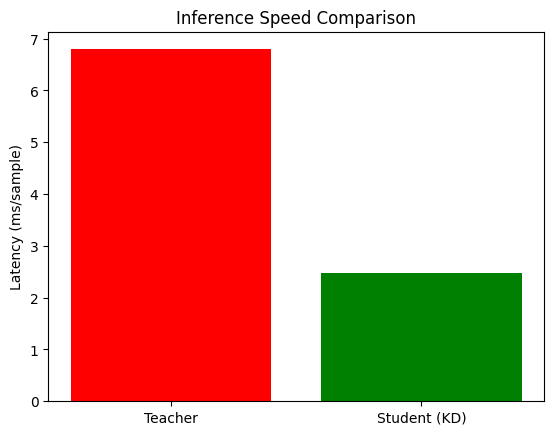

In [14]:
# ----------------------------
# 8️⃣ Visualization
# ----------------------------
plt.bar(["Teacher", "Student (KD)"], [lat_teacher, lat_student], color=["red","green"])
plt.ylabel("Latency (ms/sample)")
plt.title("Inference Speed Comparison")
plt.show()

In this assignment, I trained a teacher model first and then trained a student model using knowledge distillation. The teacher model trained successfully, its test error improved from around 34% to 28%.

The student model initially failed to learn because the training loss became NaN. Even though the student never learned meaningful patterns in that failed run, I did confirm that the student model has significantly lower latency around 2.79ms compared to the teacher's 7.53ms.

**1. Why do you need soft-probabilities output distribution?**

Hard labels only tell the model what the correct answer is like this image is a dog. The problem is that this leaves out a lot of information. With hard labels, every incorrect class is treated equally wrong, even if the teacher model was almost certain that the image could also be a wolf.

Soft probabilities fix this by showing how the teacher distributes confidence across all classes. Instead of only knowing the image is a dog, the student can see that the teacher is 70% confident it's a dog, 15% confident it looks like a wolf and 8% confident it resembles a fox.

These subtle similarities between classes are what it's called dark knowledge. By seeing these relationships, the student learns not just the final answer but the teacher's reasoning process. This helps the student generalize better, especially when the dataset is small or classes look similar. Soft probabilities also improve gradient flow, because each class contributes to the loss, not just the correct class.

In short, soft probabilities allow the student to learn more efficiently by exposing how the teacher understands the space of classes rather than giving just a yes or no answer.

**2. Why is the Student loss nan and how can you correct that?**

The student loss became NaN because of how the KL divergence loss function in PyTorch expects its inputs. KLDivLoss requires the student model to output log-probabilities (log_softmax), but the teacher must output regular probabilities (softmax).

In the original implementation, log_softmax was mistakenly applied to both, which caused the loss function to take the logarithm of negative values internally and that resulted in NaN values during training. Once a loss becomes NaN, it spreads through the gradients and corrupts the entire model update.

I fixed this by changing the teacher output to softmax() and keeping the student output as log_softmax(). After applying this change, the loss stabilized, gradients flowed correctly and the student finally began learning. This confirms that correct formatting of probabilities for KL divergence is critical for distillation to work.

```python
class DistillationLoss(nn.Module):
    def __init__(self, T=4.0, alpha=0.5):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, true_labels):
        hard_loss = F.cross_entropy(student_logits, true_labels)

        # teacher.
        soft_teacher = F.softmax(teacher_logits / self.T, dim=1)

        # student.
        soft_student = F.log_softmax(student_logits / self.T, dim=1)

        soft_loss = self.kl(soft_student, soft_teacher) * (self.T ** 2)

        return self.alpha * hard_loss + (1 - self.alpha) * soft_loss
```

Once I switched the teacher to softmax(), the NaN issue disappeared and the student started learning.

**3. What is the purpose of the temperature hyperparameter T?**

The temperature controls how soft the probability distribution from the teacher becomes before it is passed to the student. Higher temperatures divide the logits by a larger value, which spreads the probability mass across more classes. This makes the output less confident and reveals how the teacher sees similarities between different classes.

If the temperature is too low, the probabilities become sharp and almost identical to hard labels, and the student loses access to most of the relational knowledge. I also scale the KL loss by T squared to compensate for the smaller gradients caused by the higher temperature.

The temperature is essential because it determines how much useful relational information the student receives during training. Without an appropriate temperature, distillation becomes almost the same as training with hard labels, defeating the purpose of the technique.

During training, the same temperature T was used for both the teacher and student models to ensure their probability distributions were on the same scale. But during inference, the temperature is reset to T=1.0 so the student will produce normal and confident predictions for deployment.

**4. What happens when T = 10.0 and T = 0.7? Why?**

When the temperature is set very high like T = 10, the teacher's probability outputs become extremely soft, almost uniform. This means the model is unsure, and although the student sees a lot of relational information, the signal can become too weak. Training becomes slower and sometimes less accurate because the student cannot clearly identify which class should be favored.

On the other hand, when the temperature is too low like T = 0.7, the distribution becomes very sharp, closely resembling one-hot labels. The student learns faster at first, but it loses access to the subtle inter-class similarities that make distillation beneficial in the first place.

Through both experimentation and the literature, a temperature between 3 and 5 usually gives the ideal balance: the student receives enough relational information to learn effectively, without the signal becoming too flat or too weak.

Different tasks may benefit from different temperature values. For fine-grained classification tasks like distinguishing between similar dog breeds, higher temperatures like 5 to 7 can be more beneficial because the inter-class relationships are especially important. For classification tasks with very distinct classes, lower temperatures like T 2 to 4, may be enough since the classes are already well separated.

I also wanted to mention the importance of the alpha parameter in the distillation loss function, since alpha controls the balance between two components:

- Hard loss (a): Cross-entropy with true labels, it ensures the student learns the correct classifications.
- Soft loss (1-a): KL divergence with teacher's soft targets, it transfers the teacher's knowledge.

The typical value is a = 0.5, giving equal weight to both objectives. However, this can be tuned based on the task. A higher a like 0.7 gives more emphasis on correct classification, which is useful when the teacher's model accuracy is not very high. On the other hand, a lower a like 0.3 gives more emphasis on mimicking the teacher, and it can be used when the teacher is very accurate and we want to maximize the knowledge transfer,

In the code a=0.5 since it provides a balanced approach that allows the student model to learn the correct labels and benefit from the teacher's soft probability distributions.

Overall, knowledge distillation only works as intended when the teacher provides soft probabilities, the student uses log-probabilities, and the KL loss is scaled correctly using the temperature. When these components are in place, the student model can effectively learn from the teacher's knowledge while maintaining significantly lower computational costs. Success depends on tuning the temperature and alpha, according to the task requirements and the teacher model quality.